#AUTOENCODER with SKIPS for DENOISING (TILES)

This is an autoencoder with skips used to denoise rendered images that are rendered with path traceing at 1 sample per pixel:

INPUTS:
- raw 1spp image
- normal image
- UV image
- shadows image 

#IMPORTS OF SCRIPT

In [ ]:
#IMPORT COMPUTE AND VISUALIZATION LIBs
import matplotlib.pyplot as plt
 
import numpy as np
 
# set older version of tf (keras2onnx not working with tf 2.2.4)
%tensorflow_version 1.x
import tensorflow as tf
 
from PIL import Image, ImageOps
 
from matplotlib import cm

TensorFlow 1.x selected.


In [ ]:
#import KERAS for model construction

# using the keras Model for the autoencoder NN
from keras.models import Model
# import of different layers for the model (each layer will be described when used)
from keras.layers import GlobalMaxPooling2D, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, MaxPool2D, BatchNormalization, UpSampling2D, Concatenate, Dropout, Add, Permute
# activation layer
from keras.layers.advanced_activations import LeakyReLU
# initializer used for the Conv2DTranspose
from keras.initializers import orthogonal
# import of the keras backend as K
import keras.backend as K

#GET ACCESS TO G-DRIVE

In [ ]:
#import of G-drive in order to use dataset stored in google drive (this require acces to my personal G-Drive where I stored the dataset used to train the NN)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function used to import list of paths of dataset images
import os   #os is used to access to paths
imagePath = "drive/My Drive/Datasets/"  #this is the path where the dataset is stored
 
#funcion used to load all files path (path is subfolder/s, str is the name of the final folder, ext is the extention of the files to load)
def loadImages(path, str, ext):
    image_files = sorted([os.path.join(path, str, file) for file in os.listdir(path + "/"+str) if file.endswith('.'+ext)])  #get path of the images
    return image_files

Each Set of images is the set of 4 different images and a reference image
- 1spp
- normal
- shadow
- uv
- reference image


In [ ]:
#get all list of images of TRAIN and TEST DATASET

#trainset
datasetTrainColor = loadImages(imagePath + 'TRAINSET','1spp','png')
datasetTrainNormal = loadImages(imagePath + 'TRAINSET','normal','png')
datasetTrainShadow = loadImages(imagePath + 'TRAINSET','shadow','png')
datasetTrainUV = loadImages(imagePath + 'TRAINSET','UV','png')
datasetTrain_Y = loadImages(imagePath + 'TRAINSET','reference','png')
 
#testset
datasetTestColor = loadImages(imagePath,'TESTSET/1spp','png')
datasetTestNormal = loadImages(imagePath,'TESTSET/normal','png')
datasetTestShadow = loadImages(imagePath,'TESTSET/shadow','png')
datasetTestUV = loadImages(imagePath,'TESTSET/UV','png')
datasetTest_Y = loadImages(imagePath,'TESTSET/reference','png')

#Other main parameters

In [ ]:
#random seed to shuffle array for train and test
seed = np.random.randint(0,10000)

#FUNCTIONS

this are functon used inside the notepad to modify the sets of images in order to make them functional for the NN

##Padding function

<b>padNpArrayIm</b> is used to pad each image of the numpy array vertically in order to make each image divisible by 128x128 px squares

Each image is rendered in resolution: 1280 x 720

Each image is padded to a resolution: 1280 x 768

In [ ]:
#padding of images in numpy array (this is done in order to have an image divisible in 128x128px squares (1280x720) -> (1280x768))
def padNpArrayIm(npArray,pad):
    return np.pad(npArray,pad)  #pad is an internal function of numpy library 
 
# inputs are: array and pad dimension in vector4 (n,h,w,ch) -> in this case (0,48,0,0)  can be specified the dimention in begin or end of dimention  ((n_up,n_dw),(h_up,h_dw),(w_up,w_dw),(ch_up,ch_dw)) -> ((0,0),(24,24),(0,0),(0,0))

##Crop image function
 
<b>cropNpArrayIm</b> is used to crop each image of the numpy array in multiple images of 128x128px dimention. It returns a numpy array where all images of that specic dataset are stored

In [ ]:
#cropping of images in numpy array
def cropNpArrayIm(npArray,h_w): #sqare crop h = w = h_w
    outArray = np.empty((0,h_w,h_w,3));

    #here a for is used to take each image of the array and crop using the numpy function array_split on each axis
    for im in npArray:
        imageCropX = np.array(np.array_split(im,int(npArray.shape[1]/h_w),axis=0));             #the image is split in (shape[1]/h_w) parts horizontally
        imageCropY = np.array(np.array_split(imageCropX,int(npArray.shape[2]/h_w),axis=2));     #the images resulted from the firts split are split in (shape[2]/h_w) parts vertically
        imageCropY = np.concatenate(imageCropY, axis=0)                                         #the cropped images are concatenated to result a single array
        outArray = np.concatenate((outArray,imageCropY),axis=0)                                 #the out array is fulled by the images
    return outArray

##Merge image function

<b>mergingImage</b> is a function used at the end of the notebook after the training: when the NN is used to predict the input image is a high res image compared to the input images for the NN (128x128) so the input is sliced in little images and than merged together using this function

input:
- array: array of images to merge
- numberOutImage: numbers of images that has to result
- widthImage: width of Output Image
- heightImage: height of the Output Image
- h_w: dimention of each little slice (height = width = 128 -> only in this case)
<br><br>
Example of the merge sequence:<br>
- input sequence of 60 x 128 x 128 image
- images are merged horizontally: 1 x 7680 x 128
- this image is crop by width of out image (1280) horizontally: 6 x 1280 x 128
- images are merged vertically: 1 x 1280 x 768

In [ ]:
#merging the sliced images in complete images (numpy arrays)
def mergingImage(array,numberOutImage,widthImage,heightImage,h_w):
    numberOfImagesInX = widthImage/h_w      #how many images are in the X axis
    numberOfImagesInY = heightImage/h_w     #how many images are in the Y axis
    concX = np.concatenate(array,axis=0)    #concatenate each image to the otherone in sequence horizontally
    concX = np.array(np.array_split(concX,numberOutImage*numberOfImagesInX,axis=0))     #crop the concat sequence by the dimention horizzontally of the output image
    concY = np.concatenate(concX,axis=1)    #concatenate the big horizontal sequences vertically
    concY = np.array(np.array_split(concY,numberOutImage,axis=1))   #crop the big sequence by the dimention vertically of the output
    return concY


##Load images from drive as numpy array

<b>loadImageToNumpy</b> is a function used to load the dataset in numpy arrays: given the path dataset all images are loaded using (PIL) to a Numpy array

In [ ]:
#load from images (PIL) to numpy array (NPARRAY)
def loadImageToNumpy(dataset):
    imagesInArray = []  #this will be the out list (later will be changed in array)
    for im in dataset:  #foreach image path in dataset
        image = Image.open(im)  #load the file as image
        imagesInArray.append(image) #append the image as element of list
    imagesInArray = np.array([np.array(fname) for fname in imagesInArray])  #transform each element of list in numpy array
    return imagesInArray

#LOAD AND PRE-PROCESS OF THE DATASETS

Trainset and testset are loaded and processed

Each process is the same so only trainset will be deeply described, testset will be similar to trainset

##TRAINSET IMPORT

Import of the trainset as numpy array and preprocess:
- load array
- shuffle array
- normalize array
- crop array

<br>The images of the trainset are padded vertically in order to fit the crop (128x128)

In [ ]:
# finalShape = 0

###IMPORT COMPONENTS

Each set has 4 images as component input and 1 reference as output

####COLOR

This is the component of color: it is the render scene using Ray tracing, but only using 1 sample each pixel this way the image is a lot noisy but it is a fast way to output a render image with color features, similar to the output, but noisy

In [ ]:
X_train_1spp = loadImageToNumpy(datasetTrainColor)  #load the set of image from the database
datasetTrainColor = 0   #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved
print(X_train_1spp.shape)   #print the shape
X_train_1spp = padNpArrayIm(X_train_1spp,((0,0),(24,24),(0,0),(0,0)))   #pading of each image loaded
print(X_train_1spp.shape)   #print new shape

(32, 720, 1280, 3)
(32, 768, 1280, 3)


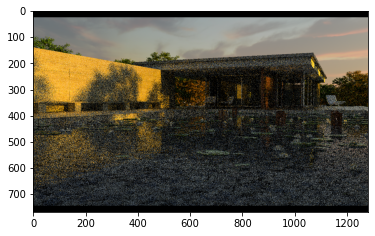

In [ ]:
#example image of the first set (image 0 of the set padded)
plt.imshow(X_train_1spp[0])

####NORMAL

This is the normal component: it contains the information of all normals of objects in the scene. Normals are the information that allow to know how the ray will bounce on a specific surface

In [ ]:
X_train_normal = loadImageToNumpy(datasetTrainNormal)   #load the set of image from the database
datasetTrainNormal = 0    #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved
print(X_train_normal.shape)     #print the shape
X_train_normal = padNpArrayIm(X_train_normal,((0,0),(24,24),(0,0),(0,0)))   #padding of each image loaded
print(X_train_normal.shape)     #print the new shape

(32, 720, 1280, 3)
(32, 768, 1280, 3)


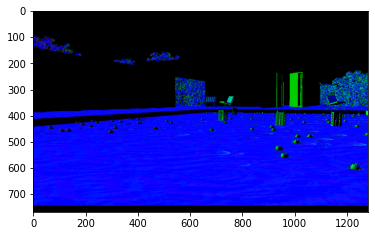

In [ ]:
#example image of the first set (image 0 of the set padded)
plt.imshow(X_train_normal[0])

####SHADOW

This is the shadow component: it contains the information of all the shadows of the scene, points where the light rays can not arrive.

This only needs 1 component, but the NN will combine the 4 components so it will remain a 3 channel image not a 1 channel image.

In [ ]:
X_train_shadow = loadImageToNumpy(datasetTrainShadow)   #load the set of image from the database
datasetTrainShadow = 0    #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved
print(X_train_shadow.shape) #print the shape
X_train_shadow = padNpArrayIm(X_train_shadow,((0,0),(24,24),(0,0),(0,0)))   #padding of each image loaded
print(X_train_shadow.shape) #print the new shape

(32, 720, 1280, 3)
(32, 768, 1280, 3)


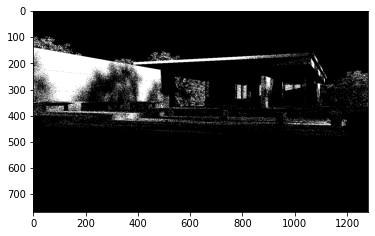

In [ ]:
#example image of the first set (image 0 of the set padded)
plt.imshow(X_train_shadow[0])

####UV

This is the UV component: it contains the information of the first bounce of the ray, the direction where it bounce as a UV.

This only needs 2 component, but as the shadow it needs to remain a 3 channel image.

In [ ]:
X_train_uv = loadImageToNumpy(datasetTrainUV)   #load the set of image from the database
datasetTrainUV = 0    #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved
print(X_train_uv.shape)     #print the shape
X_train_uv = padNpArrayIm(X_train_uv,((0,0),(24,24),(0,0),(0,0)))   #padding of each image loaded
print(X_train_uv.shape)     #print the new shape

(32, 720, 1280, 3)
(32, 768, 1280, 3)


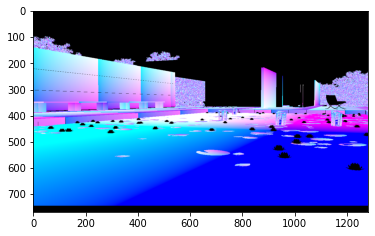

In [ ]:
#example image of the first set (image 0 of the set padded)
plt.imshow(X_train_uv[0])

###Shuffle and normalize arrays

The dataset is created using a series of render images created in sequence. In order to not specialize the NN for sequences the array is shuffled, than all the images of the array are normalized from [0,255] to [0,1]

In [ ]:
#check the shapes of the arrays
print("1spp: ",X_train_1spp.shape)
print("normal: ",X_train_normal.shape)
print("shadow: ",X_train_shadow.shape)
print("uv: ",X_train_uv.shape)

1spp:  (32, 768, 1280, 3)
normal:  (32, 768, 1280, 3)
shadow:  (32, 768, 1280, 3)
uv:  (32, 768, 1280, 3)


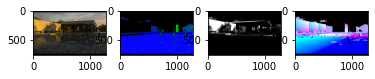

In [ ]:
#check of the components printing them
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_train_1spp[0])
axs[1].imshow(X_train_normal[0])
axs[2].imshow(X_train_shadow[0])
axs[3].imshow(X_train_uv[0])

In order to shuffle the arrays all arrays need to be shuffled in the same way so a random seed is used (the seed is different to the seed used in the test set)

In [ ]:
# shuffle all arrays
np.random.seed(seed)    #set the seed
np.random.shuffle(X_train_1spp) #shuffle the array
np.random.seed(seed)
np.random.shuffle(X_train_normal)
np.random.seed(seed)
np.random.shuffle(X_train_shadow)
np.random.seed(seed)
np.random.shuffle(X_train_uv)

In [ ]:
# normalize all arrays

X_train_1spp = X_train_1spp.astype('float32')/255.0     #normalize each array
X_train_normal = X_train_normal.astype('float32')/255.0
X_train_shadow = X_train_shadow.astype('float32')/255.0
X_train_uv = X_train_uv.astype('float32')/255.0

###CROP TRAINSET

Crop all the trainsets in order to have smaller images (128x128px).

The NN can work with 128x128 images the function used is described at the top of the notebook

In [ ]:
X_train_1spp_crop = cropNpArrayIm(X_train_1spp,128)     #crop the array and save it in a different array (this is done because, in debug, it can happen that both arrays are needed)
X_train_1spp = 0    #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved (set to 0 if not in debug)
X_train_normal_crop =cropNpArrayIm(X_train_normal,128)
X_train_normal = 0
X_train_shadow_crop = cropNpArrayIm(X_train_shadow,128)
X_train_shadow = 0
X_train_uv_crop = cropNpArrayIm(X_train_uv,128)
X_train_uv = 0

In [ ]:
#check the new shapes of arrays
print(X_train_1spp_crop.shape)
print(X_train_normal_crop.shape)
print(X_train_shadow_crop.shape)
print(X_train_uv_crop.shape)

(1920, 128, 128, 3)
(1920, 128, 128, 3)
(1920, 128, 128, 3)
(1920, 128, 128, 3)


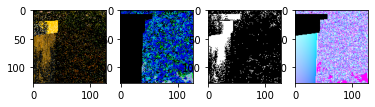

In [ ]:
#check one of the images of each array in order to be the same
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_train_1spp_crop[50])
axs[1].imshow(X_train_normal_crop[50])
axs[2].imshow(X_train_shadow_crop[50])
axs[3].imshow(X_train_uv_crop[50])

##TRAINSET REFERENCE IMPORT

import the reference images for the trainset

This images are rendered with a high number of samples per pixel and using blender Denoising function after render

In [ ]:
Y_train = loadImageToNumpy(datasetTrain_Y)  #load images from dataset
datasetTrain_Y = 0 #setting an array to 0 allow the program to delate from memory this variable, so some memory can be saved
print(Y_train.shape)    #print shape of array

(32, 720, 1280, 3)


In [ ]:
Y_train = padNpArrayIm(Y_train,((0,0),(24,24),(0,0),(0,0)))     #padding of the images
print(Y_train.shape)    #print new shape

(32, 768, 1280, 3)


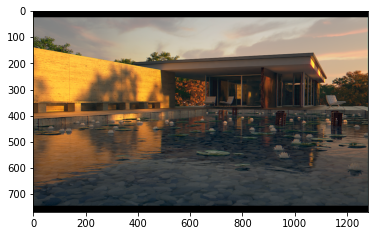

In [ ]:
#example image of the first set (image 0 of the set padded)
plt.imshow(Y_train[0])

In [ ]:
#normalization of the reference dataset
Y_train = Y_train.astype('float32')/255.0
#shuffle reference images in order to match with the trainset
np.random.seed(seed)    #set a seed (same as the trainset 4 components)
np.random.shuffle(Y_train)  #shuffle array

###Crop trainset reference as numpyArray

In [ ]:
Y_train_crop = cropNpArrayIm(Y_train,128)   #crop the array and save in a new one
Y_train = 0     #set old array to 0 to save memory

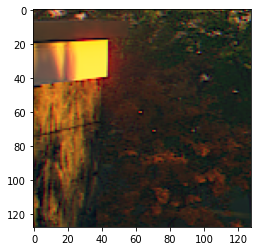

In [ ]:
#example image of the first set cropped
plt.imshow(Y_train_crop[50])

Before loading the other datasets a garbage collect is done in order to free memory from useless data (all the = 0 arrays)

In [ ]:
import gc
gc.collect()

74

##TESTSET IMPORT

The Testset is pretty much the same as the Trainset. It is composed by renders of a different scene

###IMPORT COMPONENTS

####COLOR

In [ ]:
X_test_1spp = loadImageToNumpy(datasetTestColor)    #load the dataset
datasetTestColor = 0    #save memory
print(X_test_1spp.shape)    
X_test_1spp = padNpArrayIm(X_test_1spp,((0,0),(24,24),(0,0),(0,0)))     #pad array
print(X_test_1spp.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


####NORMAL

In [ ]:
X_test_normal = loadImageToNumpy(datasetTestNormal)     #load the dataset
datasetTestNormal = 0     #save memory
print(X_test_normal.shape)  
X_test_normal = padNpArrayIm(X_test_normal,((0,0),(24,24),(0,0),(0,0)))     #pad array
print(X_test_normal.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


####SHADOW

In [ ]:
X_test_shadow = loadImageToNumpy(datasetTestShadow)     #load dataset
datasetTestShadow = 0     #save memory
print(X_test_shadow.shape)
X_test_shadow = padNpArrayIm(X_test_shadow,((0,0),(24,24),(0,0),(0,0)))     #pad array
print(X_test_shadow.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


####UV

In [ ]:
X_test_uv = loadImageToNumpy(datasetTestUV)     #load dataset
datasetTestUV = 0     #save memory
print(X_test_uv.shape)
X_test_uv = padNpArrayIm(X_test_uv,((0,0),(24,24),(0,0),(0,0)))     #pad array
print(X_test_uv.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


###Shuffle and normalize arrays

In [ ]:
#check shape array
print("1spp: ",X_test_1spp.shape)
print("normal: ",X_test_normal.shape)
print("shadow: ",X_test_shadow.shape)
print("uv: ",X_test_uv.shape)

1spp:  (65, 768, 1280, 3)
normal:  (65, 768, 1280, 3)
shadow:  (65, 768, 1280, 3)
uv:  (65, 768, 1280, 3)


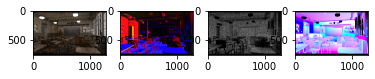

In [ ]:
#print images
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_test_1spp[0])
axs[1].imshow(X_test_normal[0])
axs[2].imshow(X_test_shadow[0])
axs[3].imshow(X_test_uv[0])

In [ ]:
#shuffle all arrays (different seed from the trainset, equal between each componet)
np.random.seed(seed+1000)   #set seed
np.random.shuffle(X_test_1spp)  #shuffle array
np.random.seed(seed+1000)
np.random.shuffle(X_test_normal)
np.random.seed(seed+1000)
np.random.shuffle(X_test_shadow)
np.random.seed(seed+1000)
np.random.shuffle(X_test_uv)

In [ ]:
# normalize all arrays
X_test_1spp = X_test_1spp.astype('float32')/255.0
X_test_normal = X_test_normal.astype('float32')/255.0
X_test_shadow = X_test_shadow.astype('float32')/255.0
X_test_uv = X_test_uv.astype('float32')/255.0

###CROP TESTSET

Each array is cropped in 128x128 px image array

In [ ]:
X_test_1spp_crop = cropNpArrayIm(X_test_1spp,128)   #crop array
X_test_1spp = 0     #save memory
X_test_normal_crop =cropNpArrayIm(X_test_normal,128)
X_test_normal = 0
X_test_shadow_crop = cropNpArrayIm(X_test_shadow,128)
X_test_shadow = 0
X_test_uv_crop = cropNpArrayIm(X_test_uv,128)
X_test_uv = 0

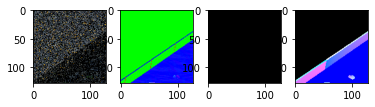

In [ ]:
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_test_1spp_crop[50])
axs[1].imshow(X_test_normal_crop[50])
axs[2].imshow(X_test_shadow_crop[50])
axs[3].imshow(X_test_uv_crop[50])

garbage collect before going on with other loads

In [ ]:
gc.collect()

37

##TESTSET REFERENCE IMPORT

This is the testset reference array loaded and pre processed

In [ ]:
Y_test = loadImageToNumpy(datasetTest_Y)    #load the dataset
datasetTest_Y = 0   #save memory
print(Y_test.shape)

(65, 720, 1280, 3)


In [ ]:
Y_test = padNpArrayIm(Y_test,((0,0),(24,24),(0,0),(0,0)))   #pad each image of array
print(Y_test.shape)

(65, 768, 1280, 3)


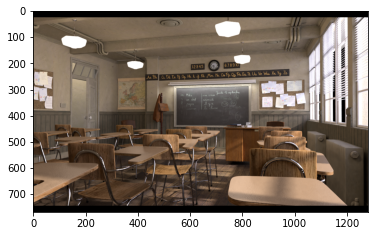

In [ ]:
plt.imshow(Y_test[0])

In [ ]:
#normalize image
Y_test = Y_test.astype('float32')/255.0
#shuffle array as the 4 components of the testset
np.random.seed(seed+1000)
np.random.shuffle(Y_test)

####Crop testset reference as numpyArray

In [ ]:
Y_test_crop = cropNpArrayIm(Y_test,128)     #crop array image
Y_test = 0  #save memory

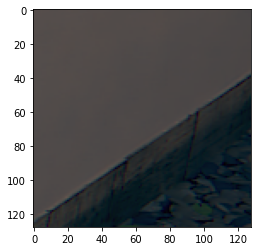

In [ ]:
plt.imshow(Y_test_crop[50])

In [ ]:
gc.collect()

0

#INPUT PARAMETER CHECK

In [ ]:
#TRAIN
print('TRAINSET')
print('1spp: ',X_train_1spp_crop.shape)
print('Normal: ',X_train_normal_crop.shape)
print('Shadow: ',X_train_shadow_crop.shape)
print('UV: ',X_train_uv_crop.shape)

print('Reference: ',Y_train_crop.shape)

#TEST
print('TESTSET')
print('1spp: ',X_test_1spp_crop.shape)
print('Normal: ',X_test_normal_crop.shape)
print('Shadow: ',X_test_shadow_crop.shape)
print('UV: ',X_test_uv_crop.shape)

print('Reference: ',Y_test_crop.shape)


TRAINSET
1spp:  (1920, 128, 128, 3)
Normal:  (1920, 128, 128, 3)
Shadow:  (1920, 128, 128, 3)
UV:  (1920, 128, 128, 3)
Reference:  (1920, 128, 128, 3)
TESTSET
1spp:  (3900, 128, 128, 3)
Normal:  (3900, 128, 128, 3)
Shadow:  (3900, 128, 128, 3)
UV:  (3900, 128, 128, 3)
Reference:  (3900, 128, 128, 3)


#AUTOENCODER

This Autoencoder uses 4 different 3 channel inputs to generate a single 3 channel output

In [ ]:
#single inputs shape
in_shape_1spp = (X_train_1spp_crop.shape[1:])
print('Single input 1 lr:', in_shape_1spp)
in_shape_normal = X_train_normal_crop.shape[1:]
print('Single input 2 lr:', in_shape_normal)
in_shape_shadow = X_train_shadow_crop.shape[1:]
print('Single input 3 lr:', in_shape_shadow)
in_shape_uv = X_train_uv_crop.shape[1:]
print('Single input 4 lr:', in_shape_uv)

Single input 1 lr: (128, 128, 3)
Single input 2 lr: (128, 128, 3)
Single input 3 lr: (128, 128, 3)
Single input 4 lr: (128, 128, 3)


##Definition of Layers

Define convolutional layer and its transpose (multiple layer inside)

ENCODING:
- Conv2D (with LeakyReLU)
- MaxPooling

DECODING:
- UpSampling
- TransposeConv2D (with LeakyReLU)

There are also some skips between layers in order to lose the less features possible: in keras the skip is done by concatenating or adding two different output of layers

Layer Definition:
<h1>Conv2D</h1>
This layer create a convolution kernel that creates an output tensor using the input layer

---

<h1>MaxPooling2D</h1>
Maxpool is used to downsample the layer input in a lower res output. This is done using a window that moves around the image with a shift defined in the stride variable of the layer<br>
Dimentions of output compared to input:

```
#if padding is valid
output_shape = (input_shape - pool_size + 1) / strides)

#if padding is same
output_shape = input_shape / strides
```

---

<h1>BatchNormalization</h1>
A test with BatchNormalization layer has be done it helps mantaining the mean output close to 0 and the standard deviation of output close to 1

---

<h1>LeakyReLU</h1>
Each layer is activated using a leakyReLU activation layer that allow a small gradient when the unit is not active

###MULTIPLE INPUT MODEL

The input are defined as:
- inputLR_[*number*]

The layer used for skip are defined as:
- enc[*number*]ForSkip

The skip layer is defined as:
- skip[*number*]

Other layers are:
- enc: each layer of encoding
- dec: each layer of decoding
- outputLayer: the out layer

In [ ]:
#simple function used after each skip 
def lrelu_bn(inputs):
   lrelu = LeakyReLU()(inputs)  #activation of the layer
   bn = BatchNormalization(axis=3)(lrelu)   #test for the BachNormalization layer
   return bn

In [ ]:
### INPUTS

#definition of the input layers (4 inputs) each is a (n x 128 x 128 x 3)
# inputLR_1 = Input(shape=in_shape_1spp, name='ENCODER_INPUT_1spp')       #definition of the first input layer
# inputLR_2 = Input(shape=in_shape_normal, name='ENCODER_INPUT_normal')
# inputLR_3 = Input(shape=in_shape_shadow, name='ENCODER_INPUT_shadow')
# inputLR_4 = Input(shape=in_shape_uv, name='ENCODER_INPUT_uv')
inputLR_1 = Input(shape=(None,None,3), name='ENCODER_INPUT_1spp')       #definition of the first input layer
inputLR_2 = Input(shape=(None,None,3), name='ENCODER_INPUT_normal')
inputLR_3 = Input(shape=(None,None,3), name='ENCODER_INPUT_shadow')
inputLR_4 = Input(shape=(None,None,3), name='ENCODER_INPUT_uv')
#combinbation of the inputs using a Concatenate layer (n x 128 x 128 x 12)
CombinedInput = Concatenate(axis=-1,name='concat_INPUTS')([inputLR_1,inputLR_2,inputLR_3,inputLR_4])

### ENCODER

enc1ForSkip = Conv2D(32, kernel_size=5, strides=(1,1), padding='same', name='CONV_layer_1', activation=None)(CombinedInput)  #convolutional layer  (n x 128 x 128 x 32)
enc1 = LeakyReLU(name='ACTIVATION_1')(enc1ForSkip)  #activation layer
#for the first layer there is no MaxPooling because a upsampling is done in the first decoding layer and dimentions must match

enc2ForSkip = Conv2D(43, kernel_size=3, strides=(1,1), padding='same', name='CONV_layer_2', activation=None)(enc1)   # (n x 128 x 128 x 43)
enc2 = LeakyReLU(name='ACTIVATION_2')(enc2ForSkip)
enc2 = MaxPool2D(pool_size=(2,2), strides=None, padding='same', name='maxPool2D_layer_2')(enc2) # (n x 64 x 64 x 43)

enc3ForSkip = Conv2D(57, kernel_size=3, strides=(1,1), padding='same', name='CONV_layer_3', activation=None)(enc2) # (n x 64 x 64 x 57)
enc3 = LeakyReLU(name='ACTIVATION_3')(enc3ForSkip)
enc3 = MaxPool2D(pool_size=(2,2), strides=None, padding='same', name='maxPool2D_layer_3')(enc3) # (n x 32 x 32 x 57)

enc4ForSkip = Conv2D(76, kernel_size=3, strides=(1,1), padding='same',name='CONV_layer_4', activation=None)(enc3)    #  (n x 32 x 32 x 76)
enc4 = LeakyReLU(name='ACTIVATION_4')(enc4ForSkip)
enc4 = MaxPool2D(pool_size=(2,2), strides=None, padding='same', name='maxPool2D_layer_4')(enc4) # (n x 16 x 16 x 76)

enc5ForSkip = Conv2D(101, kernel_size=3, strides=(1,1), padding='same',name='CONV_layer_5', activation=None)(enc4)   # (n x 16 x 16 x 101)
enc5 = LeakyReLU(name='ACTIVATION_5')(enc5ForSkip)
enc5 = MaxPool2D(pool_size=(2,2), strides=None, padding='same', name='maxPool2D_layer_5')(enc5) # (n x 8 x 8 x 101)

enc6ForSkip = Conv2D(101, kernel_size=3, strides=(1,1), padding='same',name='CONV_layer_6', activation=None)(enc5)   # (n x 8 x 8 x 101)
enc6 = LeakyReLU(name='ACTIVATION_6')(enc6ForSkip)
enc6 = MaxPool2D(pool_size=(2,2), strides=None, padding='same', name='maxPool2D_layer_6')(enc6) # (n x 4 x 4 x 101)

### DECODER

dec6 = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest', name='upsampling_DEC_layer6')(enc6)  #upsampling layer used to upsample the encoded layer    (n x 8 x 8 x 101)
dec6 = Conv2DTranspose(filters=101, kernel_size=3, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer6', activation=None)(dec6)   #inverse layer of Conv2D used to go back to 3 channels and decode   (n x 8 x 8 x 101)
skip6 = Add()([enc6ForSkip,dec6])   #skip layer between enc6 and dec6 to not lose quality of image  (n x 8 x 8 x 101)
dec6 = lrelu_bn(skip6)

dec5 = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest', name='upsampling_DEC_layer5')(dec6)  #   (n x 16 x 16 x 101)
dec5 = Conv2DTranspose(filters=101, kernel_size=3, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer5', activation=None)(dec5)   #(n x 16 x 16 x 101)
skip5 = Add()([enc5ForSkip,dec5])   #enc5+dec5 = (n x 16 x 16 x 101)
dec5 = lrelu_bn(skip5)

dec4 = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest', name='upsampling_DEC_layer4')(dec5)  #(n x 32 x 32 x 101)
dec4 = Conv2DTranspose(filters=76, kernel_size=3, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer4', activation=None)(dec4)    #(n x 32 x 32 x 76)
skip4 = Add()([enc4ForSkip,dec4])   #enc4+dec4 = (n x 32 x 32 x 76)
dec4 = lrelu_bn(skip4)

dec3 = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest', name='upsampling_DEC_layer3')(dec4)  #(n x 64 x 64 x 76)
dec3 = Conv2DTranspose(filters=57, kernel_size=3, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer3', activation=None)(dec3)    #(n x 64 x 64 x 57)
skip3 = Add()([enc3ForSkip,dec3])   #enc3+dec3 = (n x 64 x 64 x 57)
dec3 = lrelu_bn(skip3)

dec2 = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest', name='upsampling_DEC_layer2')(dec3)  #(n x 128 x 128 x 57)
dec2 = Conv2DTranspose(filters=43, kernel_size=3, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer2', activation=None)(dec2)    #(n x 128 x 128 x 43)
skip2 = Add()([enc2ForSkip,dec2])   #enc2+dec2 = (n x 128 x 128 x 43)
dec2 = lrelu_bn(skip2)

dec1 = Conv2DTranspose(filters=32, kernel_size=5, strides=(1,1),padding='same',kernel_initializer=orthogonal(), name='transp_CONV_DEC_layer1', activation=None)(dec2)    #(n x 128 x 128 x 32)
skip1 = Add()([enc1ForSkip,dec1])   #enc1+dec1 = (n x 128 x 128 x 32)
dec1 = lrelu_bn(skip1)

decOut = Conv2DTranspose(filters=12, kernel_size=1, strides=(1,1),padding='same',kernel_initializer=orthogonal(),name='Return_12_filt_for_skip', activation=None)(dec1)  #(n x 128 x 128 x 12)
lastSkip = Add()([CombinedInput,decOut])    #skip between the 12 channels output and the combination of the inputs = (n x 128 x 128 x 12)
lastSkip = lrelu_bn(lastSkip)

### OUTPUT

output = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1),padding='same',name='OUTPUT', activation=None)(lastSkip)    #last convolution in order to have a 3 channel output (n x 128 x 128 x 3)

skipWithFirts = Add()([inputLR_1,output])   #last skip between the first input (color component) and the last output
skipWithFirts = lrelu_bn(skipWithFirts)

autoencoder = Model(inputs=[inputLR_1,inputLR_2,inputLR_3,inputLR_4] , outputs= skipWithFirts)  #define the model with Input and Output

In [ ]:
#summarization of the autoencoder model
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ENCODER_INPUT_1spp (InputLayer) (None, None, None, 3 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_normal (InputLaye (None, None, None, 3 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_shadow (InputLaye (None, None, None, 3 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_uv (InputLayer)   (None, None, None, 3 0                                            
____________________________________________________________________________________________

##Compiling and Learning of Autoencoder

The compile of the autoencoder is done using Adam optimization and a mean absolute error as a loss. Some other losses have been tried, this one is one of the best to achieve the best result. (square min error can be also use)

In [ ]:
autoencoder.compile(loss= 'mean_squared_error' , optimizer='Adam') #compile of the model loss = mean_squared_error or mean_absolute_error

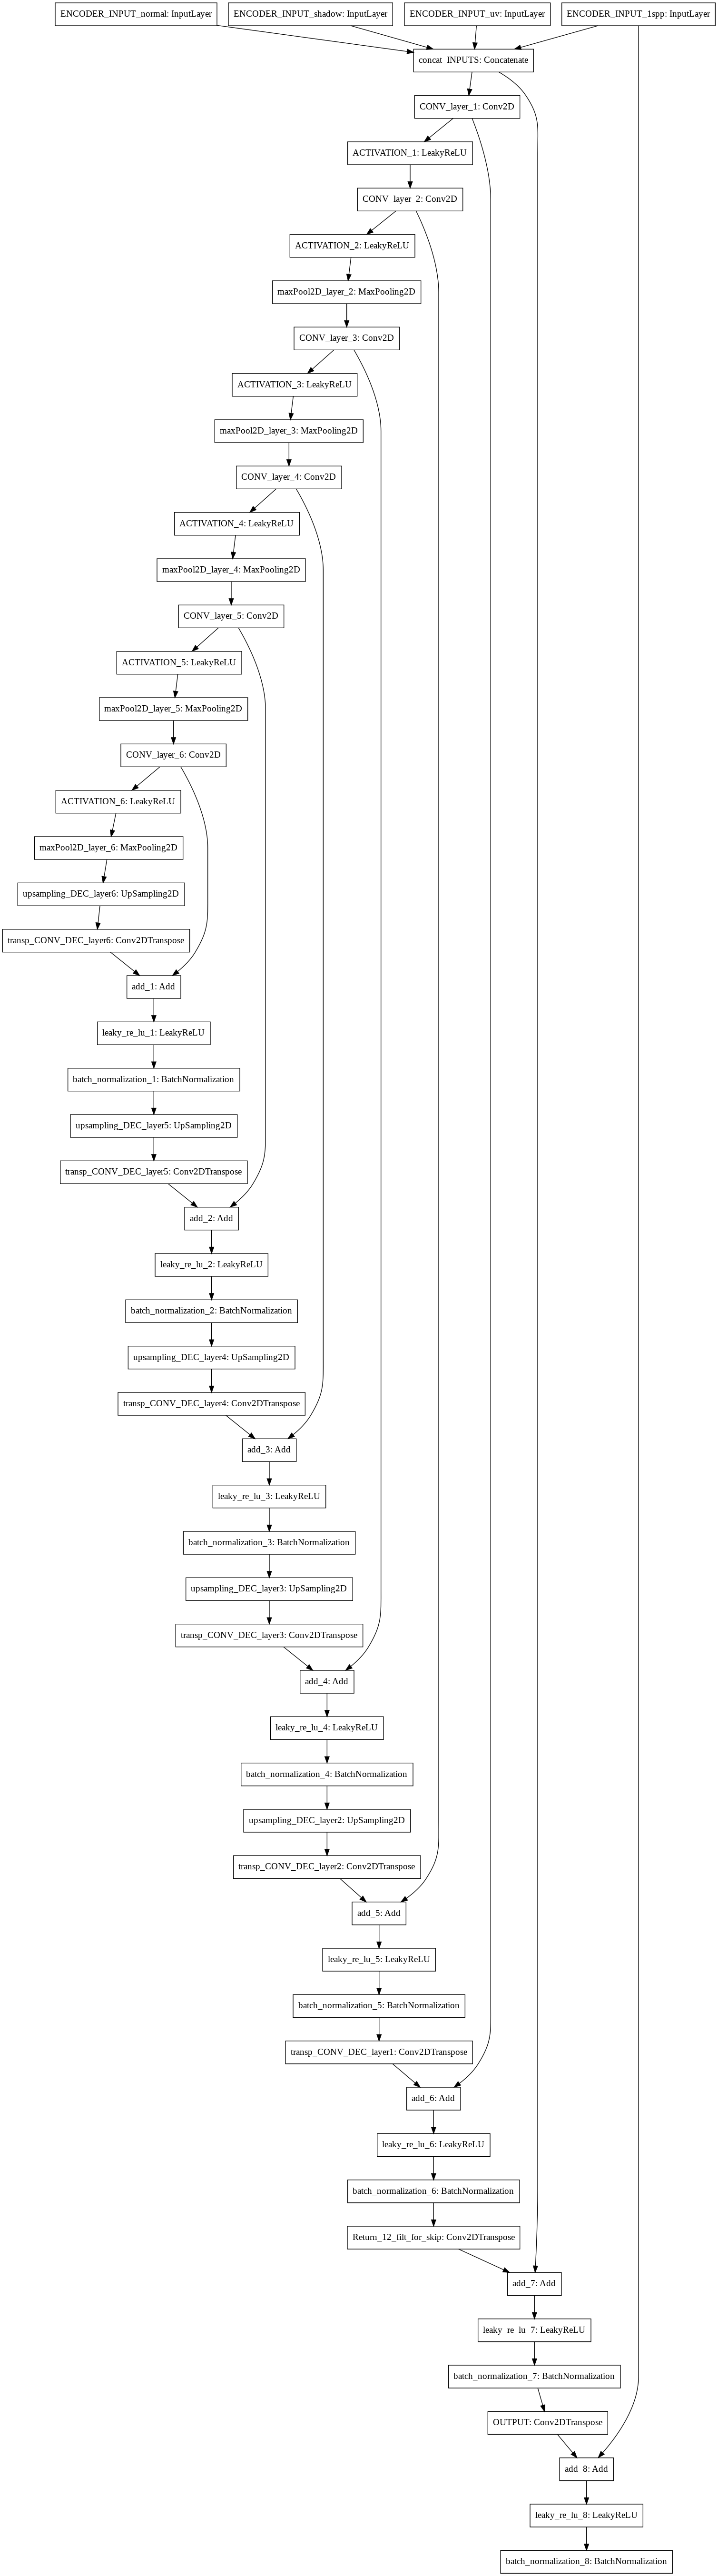

In [ ]:
#Here to plot the model as a png
tf.keras.utils.plot_model(autoencoder)

Fit of the autoencoder: it is trained using the dataset loaded before in the notebook.

Here it is trained for 90 epochs because there is not a very inproovement leaving also 100 or 200 epochs

Batch size is set to 15 because the number of images in each trainset and testset can be easily divided in groups of 15

In [ ]:
#train of the autoencoder (NB: trainset and testset are reverse because there are more images in the testset than in the trainset Later on the trainset will be updated and they will be reversed again in the right place)
autoencoder.fit([X_test_1spp_crop,X_test_normal_crop,X_test_shadow_crop,X_test_uv_crop],Y_test_crop,epochs=100,batch_size=15,validation_data=([X_train_1spp_crop,X_train_normal_crop,X_train_shadow_crop,X_train_uv_crop],Y_train_crop))

Train on 3900 samples, validate on 1920 samples
Epoch 1/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 2/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 3/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 4/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 5/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 6/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0057 - val_loss: 0.0083
Epoch 8/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 9/100
3900/3900 [==============================] - 22s 6ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 10/100
390

#VALIDATIONSET IMPORT

For the Validation set import it is all pretty much the same as train and test, the only big difference is that it is not shuffled because there is no gain in shuffling and can be usefull to see the behaviour of the NN on sequences of images


In [ ]:
#validation set path load
datasetValidationColor = loadImages(imagePath,'VALIDATION/1spp','png')
datasetValidationNormal = loadImages(imagePath,'VALIDATION/normal','png')
datasetValidationShadow = loadImages(imagePath,'VALIDATION/shadow','png')
datasetValidationUV = loadImages(imagePath,'VALIDATION/UV','png')
datasetValidation_Y = loadImages(imagePath,'VALIDATION/reference','png')

##IMPORT COMPONENTS

As for Train and Test there are 4 components and a reference

###COLOR

In [ ]:
X_val_1spp = loadImageToNumpy(datasetValidationColor)   #load dataset
datasetValidationColor = 0  #save memory
print(X_val_1spp.shape)
X_val_1spp = padNpArrayIm(X_val_1spp,((0,0),(24,24),(0,0),(0,0)))   #pad array
print(X_val_1spp.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


###NORMAL

In [ ]:
X_val_normal = loadImageToNumpy(datasetValidationNormal)    #load dataset
datasetValidationNormal = 0 #save memory
print(X_val_normal.shape)
X_val_normal = padNpArrayIm(X_val_normal,((0,0),(24,24),(0,0),(0,0)))   #pad array
print(X_val_normal.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


###SHADOW

In [ ]:
X_val_shadow = loadImageToNumpy(datasetValidationShadow)    #load dataset
datasetValidationShadow = 0     #save memory
print(X_val_shadow.shape)
X_val_shadow = padNpArrayIm(X_val_shadow,((0,0),(24,24),(0,0),(0,0)))   #pad array
print(X_val_shadow.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


###UV

In [ ]:
X_val_uv = loadImageToNumpy(datasetValidationUV)    #load dataset
datasetValidationUV = 0 #save memory
print(X_val_uv.shape)
X_val_uv = padNpArrayIm(X_val_uv,((0,0),(24,24),(0,0),(0,0)))   #pad array
print(X_val_uv.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


##Normalize arrays

In [ ]:
#check shapes
print("1spp: ",X_val_1spp.shape)
print("normal: ",X_val_normal.shape)
print("shadow: ",X_val_shadow.shape)
print("uv: ",X_val_uv.shape)

1spp:  (11, 768, 1280, 3)
normal:  (11, 768, 1280, 3)
shadow:  (11, 768, 1280, 3)
uv:  (11, 768, 1280, 3)


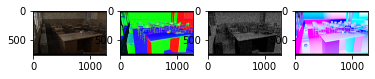

In [ ]:
#print images
fig, axs = plt.subplots(1, 4)
 
axs[0].imshow(X_val_1spp[0])
axs[1].imshow(X_val_normal[0])
axs[2].imshow(X_val_shadow[0])
axs[3].imshow(X_val_uv[0])

In [ ]:
# normalize all arrays
X_val_1spp = X_val_1spp.astype('float32')/255.0
X_val_normal = X_val_normal.astype('float32')/255.0
X_val_shadow = X_val_shadow.astype('float32')/255.0
X_val_uv = X_val_uv.astype('float32')/255.0

##CROP VALIDATIONSET

Crop images in array in bigger array of (128 x 128) px array image

In [ ]:
X_val_1spp_crop = cropNpArrayIm(X_val_1spp,128)     #crop array image
# X_val_1spp = 0      #save memory
X_val_normal_crop =cropNpArrayIm(X_val_normal,128)
# X_val_normal = 0
X_val_shadow_crop = cropNpArrayIm(X_val_shadow,128)
# X_val_shadow = 0
X_val_uv_crop = cropNpArrayIm(X_val_uv,128)
# X_val_uv = 0

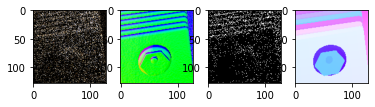

In [ ]:
#plot images cropped
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_val_1spp_crop[10])
axs[1].imshow(X_val_normal_crop[10])
axs[2].imshow(X_val_shadow_crop[10])
axs[3].imshow(X_val_uv_crop[10])

##VALIDATIONSET REFERENCE

load the reference values

In [ ]:
Y_val = loadImageToNumpy(datasetValidation_Y)   #load dataset
print(Y_val.shape)

(11, 720, 1280, 3)


In [ ]:
Y_val = padNpArrayIm(Y_val,((0,0),(24,24),(0,0),(0,0))) #pad images
print(Y_val.shape)
Y_val = Y_val.astype('float32')/255.0   #normalize images
shapeOfBigIm = Y_val.shape  #shape of the array of images (saved in order to merge later the image predicted)

(11, 768, 1280, 3)


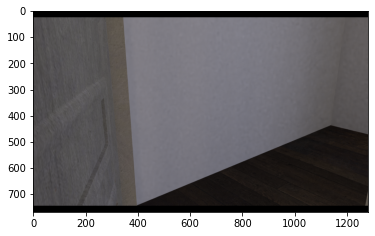

In [ ]:
plt.imshow(Y_val[0])

In [ ]:
Y_val_crop = cropNpArrayIm(Y_val,128)   #crop the array in order to obtain the same shape of the 4 components (128 x 128) px

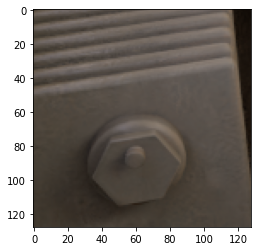

In [ ]:
plt.imshow(Y_val_crop[10])

##VALIDATION SET PADDED

The Validation set is now padded:

The idea is to delate the tiles in the output image, in order to do this a new image (padded and cropped in different ways) is created, than it is summed to the first one and a result shoud be less tiled

In [ ]:
X_val_1spp_PAD = padNpArrayIm(X_val_1spp,((0,0),(64,64),(64,64),(0,0)))
X_val_normal_PAD = padNpArrayIm(X_val_normal,((0,0),(64,64),(64,64),(0,0)))
X_val_shadow_PAD = padNpArrayIm(X_val_shadow,((0,0),(64,64),(64,64),(0,0)))
X_val_uv_PAD = padNpArrayIm(X_val_uv,((0,0),(64,64),(64,64),(0,0)))

In [ ]:
X_val_1spp_PAD_crop = cropNpArrayIm(X_val_1spp_PAD,128)     #crop array image
X_val_normal_PAD_crop =cropNpArrayIm(X_val_normal_PAD,128)
X_val_shadow_PAD_crop = cropNpArrayIm(X_val_shadow_PAD,128)
X_val_uv_PAD_crop = cropNpArrayIm(X_val_uv_PAD,128)

#PREVISION ON VALIDATIONSET

Prevision on the validation set using the NN

In [ ]:
p = autoencoder.predict([X_val_1spp,X_val_normal,X_val_shadow,X_val_uv])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


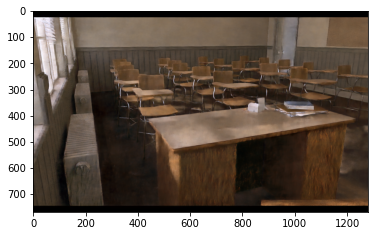

In [ ]:
plt.imshow(p[0])

In [ ]:
im = Image.fromarray(np.uint8(p[0]*255))
im.save("singleOut.png","PNG")    #save of the image as output1.png

In [ ]:
imagePredict = autoencoder.predict([X_val_1spp_crop,X_val_normal_crop,X_val_shadow_crop,X_val_uv_crop])     #autoencoder try to predict in the right way the image

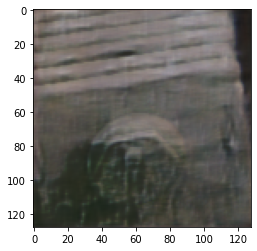

In [ ]:
plt.imshow(imagePredict[10])

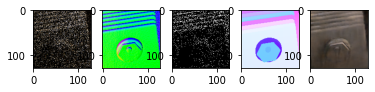

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_val_1spp_crop[10])
axs[1].imshow(X_val_normal_crop[10])
axs[2].imshow(X_val_shadow_crop[10])
axs[3].imshow(X_val_uv_crop[10])
axs[4].imshow(imagePredict[10])

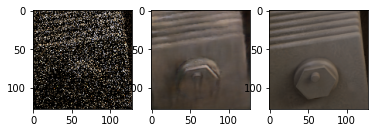

In [ ]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(X_val_1spp_crop[10])
axs[1].imshow(imagePredict[10])
axs[2].imshow(Y_val_crop[10])

prevision on padded

In [ ]:
imagePredict_PAD = autoencoder.predict([X_val_1spp_PAD_crop,X_val_normal_PAD_crop,X_val_shadow_PAD_crop,X_val_uv_PAD_crop])     #autoencoder try to predict in the right way the image

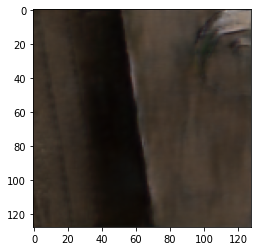

In [ ]:
plt.imshow(imagePredict_PAD[12])

#MERGE IMAGE

Merging of the image in order to get the beginning higher resolution image

In [ ]:
mergedImages = mergingImage(imagePredict,11,1280,768,128)   #function used to merge image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


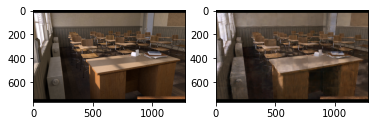

In [ ]:
#plot of reference image and merged image
fig, axs = plt.subplots(1, 2)

axs[0].imshow(Y_val[0])
axs[1].imshow(mergedImages[0])

merge padded images


In [ ]:
mergedImages_PAD = mergingImage(imagePredict_PAD,11,1408,896,128)   #function used to merge image

In [ ]:
firstGroupNotPAD = padNpArrayIm(mergedImages,((0,0),(64,64),(64,64),(0,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


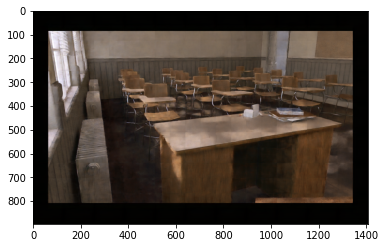

In [ ]:
summedOutput = np.add(mergedImages_PAD,firstGroupNotPAD)

summedOutput = summedOutput / 2.0

plt.imshow(summedOutput[0])

##OUTPUT OF PREDICTED IMAGES

Save the output image as a PNG 

In [ ]:
#the save is done using the PIL library
im = Image.fromarray(np.uint8(mergedImages[0]*255))
im.save("output1.png","PNG")    #save of the image as output1.png

In [ ]:
#saving inputs as images
inputIm = Image.fromarray(np.uint8(X_val_1spp[0]*255))
inputIm.save("1sppIn.png","PNG")
inputIm = Image.fromarray(np.uint8(X_val_normal[0]*255))
inputIm.save("NormalIn.png","PNG")
inputIm = Image.fromarray(np.uint8(X_val_shadow[0]*255))
inputIm.save("ShadowIn.png","PNG")
inputIm = Image.fromarray(np.uint8(X_val_uv[0]*255))
inputIm.save("UVIn.png","PNG")
#saving reference image
inputIm = Image.fromarray(np.uint8(Y_val[0]*255))
inputIm.save("Reference.png","PNG")

In [ ]:
im = Image.fromarray(np.uint8(summedOutput[0]*255))
im.save("output1.png","PNG")    #save of the image as output1.png

This is a simple test using cv2 to smooth the image (not usable because it became too blurry)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


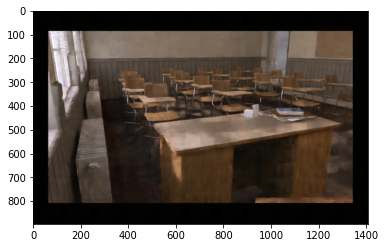

In [ ]:
import cv2

kernel = np.ones((3,3),np.float32)/9

dst = cv2.filter2D(summedOutput[0],-1,kernel)
# dst = cv2.bilateralFilter(np.uint8(mergedImages[0]*255),9,75,75)
plt.imshow(dst)

In [ ]:
im = Image.fromarray(np.uint8(dst*255))
im.save("outputCV21.png","PNG")

#MODEL SAVE

Trying to save the model as a onnx model in order to use it later in Unity3D with Barracuda

In [ ]:
#this is a way to save the model as a .h5 (keras file)

# import tempfile
# tmpdir = tempfile.mkdtemp()
# mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
# tf.saved_model.save(autoencoder,'drive/My Drive/Datasets')

In [ ]:
#install the keras to onnx converter
!pip install -U git+https://github.com/microsoft/onnxconverter-common
!pip install -U git+https://github.com/onnx/keras-onnx

  Cloning https://github.com/microsoft/onnxconverter-common to /tmp/pip-req-build-5k4r0qog
  Running command git clone -q https://github.com/microsoft/onnxconverter-common /tmp/pip-req-build-5k4r0qog
     |████████████████████████████████| 7.7MB 7.9MB/s 
  Created wheel for onnxconverter-common: filename=onnxconverter_common-1.8.0-py2.py3-none-any.whl size=71160 sha256=050989f955e7029bac60a0fbbcfb9e97737d954148e8205c0cd199b50c6121e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-gfkxrn4w/wheels/7d/97/c7/8908efff309db78064933e54f2a70427a75ada73b9b19789c3
Successfully built onnxconverter-common
  Cloning https://github.com/onnx/keras-onnx to /tmp/pip-req-build-afm6wy39
  Running command git clone -q https://github.com/onnx/keras-onnx /tmp/pip-req-build-afm6wy39
     |████████████████████████████████| 81kB 5.6MB/s 
  Created wheel for keras2onnx: filename=keras2onnx-1.8.0-cp36-none-any.whl size=100758 sha256=3f802fb22b385be9dcacca913e593dac642cf62c3e911381a1dd9d053f4ec571
  Stored in d

In [ ]:
#import the keras2onnx library
import keras2onnx

# convert to onnx model (model, inputs of the model, version of onnx output)
onnx_model = keras2onnx.convert_keras(autoencoder, channel_first_inputs=autoencoder.input_names, target_opset=7)

temp_model_file = 'modONNX.onnx'    #name of the output model
keras2onnx.save_model(onnx_model, temp_model_file)  #function used to save the model

The ONNX operator number change on the optimization: 148 -> 65
